In [1]:
import numpy as np
import os
import datetime as datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input,Dropout, LSTM,GRU, multiply,Bidirectional,Permute,Reshape,Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Model
# convert an array of values into a dataset matrix
from google.colab import drive
drive.mount('/drive')
import keras.backend as K
from numpy import array , hstack
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

Mounted at /drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd
import glob
from pathlib import Path

path = "/drive/My Drive/fastStorage/files/" # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []
j=0
for filename in all_files:
  j=j+1
  print(j)
  if(j==100):
    break
  df = pd.read_csv(filename,sep=';\t')
  df['resource_id']=int(Path(filename).stem)
  #if(j>=800):
  li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


1


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [3]:
frame["Memory usage [%]"]=frame["Memory usage [KB]"]*100/frame["Memory capacity provisioned [KB]"]

In [4]:
# df.info() ["CPU usage [%]","Memory usage [KB]","Disk read throughput [KB/s]","Disk write throughput [KB/s]","Network received throughput [KB/s]","Network transmitted throughput [KB/s]"]

In [5]:
lst = [322,324,329,331,332,338,339,340,341,342,343,344,356,357,361,367,125,135,242,245,246,183,184,185,1299,1240,186,187]
frame1 = frame.loc[frame['resource_id'].isin(lst)]

In [6]:
from keras.layers import *
class attention(Layer):
    
    def __init__(self, return_sequences=True,**kwargs):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'return_sequences': self.return_sequences 
      })
      return config
      
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)


import tensorflow as tf



In [7]:
def create_dataset(data_seq, n_steps_in, n_steps_out):


  X, y = list(), list()
  colList = data_seq.resource_id.unique();
  for col in colList:
    cluster_train_data = data_seq[data_seq['resource_id'] ==col] 
    sequences = cluster_train_data.values
    for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out-1
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1:out_end_ix, 0]
      X.append(seq_x)
      y.append(seq_y)
  return array(X), array(y)

def prepareDF(col,dataframeSet):
  df = dataframeSet[dataframeSet['resource_id'] ==col] 
  df = df.groupby([df.index]).first()
  df1 = pd.date_range(
  start=df.index.min(), end=df.index.max(),freq="5T").difference(df.index)
  #print('missing values',len(df1))
  for i in df1:
    df.loc[i] = np.nan
    #df = df.sort_index()

  # if(len(df[(df.PCT.isnull()) & (df.PCT.shift().isnull())& (df.PCT.shift().shift().isnull())])!=0):
  #   print('corrupted df',col,' length ',len(df[(df.PCT.isnull()) & (df.PCT.shift().isnull())& (df.PCT.shift().shift().isnull())]))
  #   #df =pd.DataFrame()
    
  # else:
    #print('not corrupted df',col,)
  df = df.sort_index()
  df = df.fillna(method='ffill')
  df = df.fillna(method='bfill')
  df = df.groupby(df.index).last()
  return df

  

In [8]:
from datetime import datetime
frame['Datetime'] = pd.to_datetime(frame['Timestamp [ms]'], 
                                  unit='s')
frame = frame.drop(['Timestamp [ms]'], axis = 1)
frame=frame.set_index('Datetime')

In [9]:
#fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dfs = []

#dataframeSet = pd.read_csv('/drive/My Drive/massive.csv',index_col='start_interval',parse_dates=True)
dataframeSet = frame[[ 'CPU usage [%]','resource_id']]
dataframeSet['id']=dataframeSet['resource_id']
dataframeSet = dataframeSet[dataframeSet['resource_id'].notna()]
i=0
for col in dataframeSet.resource_id.unique():
  if(i==100):
    break;
  dfs.append(prepareDF(col,dataframeSet))
  i=i+1
  print("cluster-id",i)
dataframe = pd.concat(dfs, axis=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


cluster-id 1
cluster-id 2
cluster-id 3
cluster-id 4
cluster-id 5
cluster-id 6
cluster-id 7
cluster-id 8
cluster-id 9
cluster-id 10
cluster-id 11
cluster-id 12
cluster-id 13
cluster-id 14
cluster-id 15
cluster-id 16
cluster-id 17
cluster-id 18
cluster-id 19
cluster-id 20
cluster-id 21
cluster-id 22
cluster-id 23
cluster-id 24
cluster-id 25
cluster-id 26
cluster-id 27
cluster-id 28
cluster-id 29
cluster-id 30
cluster-id 31
cluster-id 32
cluster-id 33
cluster-id 34
cluster-id 35
cluster-id 36
cluster-id 37
cluster-id 38
cluster-id 39
cluster-id 40
cluster-id 41
cluster-id 42
cluster-id 43
cluster-id 44
cluster-id 45
cluster-id 46
cluster-id 47
cluster-id 48
cluster-id 49
cluster-id 50
cluster-id 51
cluster-id 52
cluster-id 53
cluster-id 54
cluster-id 55
cluster-id 56
cluster-id 57
cluster-id 58
cluster-id 59
cluster-id 60
cluster-id 61
cluster-id 62
cluster-id 63
cluster-id 64
cluster-id 65
cluster-id 66
cluster-id 67
cluster-id 68
cluster-id 69
cluster-id 70
cluster-id 71
cluster-id 72
c

In [12]:
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
dataframe[:]=dataset
dataframe['resource_id'][:]=dataframe['resource_id'].apply(lambda x:float(format( x,".6f")))


In [13]:
import datetime
train = dataframe[dataframe.index<datetime.datetime(2013, 9, 8)] 
test = dataframe[dataframe.index>datetime.datetime(2013, 9, 8)]
#train = train[train['database_id'] ==col]
look_back = 48
out_num=192
trainX, trainY = create_dataset(train, look_back,out_num)
print ("X.shape" , trainX.shape) 
print ("y.shape" , trainY.shape)

batch_size = 1
#time_steps = 193
features = 3
stateful = False
single = False
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1],features))
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1]))
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

custom_early_stopping = EarlyStopping(
    monitor='loss', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
)

input = Input(batch_input_shape=(batch_size,look_back,features), name='input', dtype='float32')
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=None, decay=0.0)
model = Sequential()
model.add(input)
model.add(Bidirectional(GRU(24, return_sequences=True,return_state=False,stateful=stateful)))
model.add(Dropout(0.25))
model.add(Bidirectional(GRU(12, return_sequences=True,return_state=False,stateful=stateful)))
model.add(Dropout(0.25))
model.add(Bidirectional(GRU(8, return_sequences=True,return_state=False,stateful=stateful)))
model.add(Dropout(0.25))
model.add(attention(return_sequences=False))
# model.add(Bidirectional(LSTM(16, return_sequences=True,return_state=False,stateful=stateful)))
#model.add(Dropout(0.25))
# model.add(Bidirectional(LSTM(32, return_sequences=False,return_state=False,stateful=stateful)))
model.add(Dense(units=out_num))#,activation='linear',kernel_constraint=tf.keras.constraints.NonNeg()


#model.compile(optimizer= optimizer, loss='mean_squared_error', metrics=[rmse],run_eagerly=True)
model.compile(metrics=[rmse],run_eagerly=True,loss='mean_squared_error', optimizer=optimizer)
history = model.fit(trainX, trainY, batch_size=5000, epochs=60, verbose=2, validation_split=0.3,callbacks=[custom_early_stopping])

X.shape (1429236, 48, 3)
y.shape (1429236, 192)
Epoch 1/60
201/201 - 21s - loss: 0.0020 - rmse: 0.0271 - val_loss: 0.0819 - val_rmse: 0.1186 - 21s/epoch - 102ms/step
Epoch 2/60
201/201 - 20s - loss: 0.0013 - rmse: 0.0216 - val_loss: 0.0514 - val_rmse: 0.0942 - 20s/epoch - 100ms/step
Epoch 3/60
201/201 - 20s - loss: 8.5206e-04 - rmse: 0.0155 - val_loss: 0.0369 - val_rmse: 0.0761 - 20s/epoch - 99ms/step
Epoch 4/60
201/201 - 20s - loss: 6.8593e-04 - rmse: 0.0117 - val_loss: 0.0378 - val_rmse: 0.0746 - 20s/epoch - 100ms/step
Epoch 5/60
201/201 - 20s - loss: 6.4722e-04 - rmse: 0.0105 - val_loss: 0.0409 - val_rmse: 0.0776 - 20s/epoch - 100ms/step
Epoch 6/60
201/201 - 20s - loss: 6.3645e-04 - rmse: 0.0101 - val_loss: 0.0430 - val_rmse: 0.0799 - 20s/epoch - 100ms/step
Epoch 7/60
201/201 - 20s - loss: 6.3043e-04 - rmse: 0.0099 - val_loss: 0.0444 - val_rmse: 0.0800 - 20s/epoch - 100ms/step
Epoch 8/60
201/201 - 20s - loss: 6.2540e-04 - rmse: 0.0097 - val_loss: 0.0457 - val_rmse: 0.0812 - 20s/epoc

In [14]:
model.save("model_bilstm_cpu.h5")
from keras.models import load_model
saved_model = load_model("model_bilstm_cpu.h5",custom_objects={'attention': attention,'rmse':rmse})

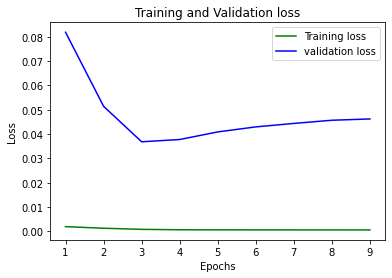

In [15]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = list([1,2,3,4,5,6,7,8,9])#,10,11,12,13,14,15,16,17,18,19,20])
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
i=0
total_rmse=0
disy=""

for col in train.resource_id.unique():
  test_col=col
  #print('column value---------',col,float(format( test_col,".5f")))
  lenT=len(train[train['resource_id'] ==test_col])
  #print("------------------------length ",lenT)

  #df_filtered = dataframe[dataframe['resource_id'] ==test_col]
  train_filtered = train[train['resource_id'] ==test_col]
  #predictList = train_filtered[len(train_filtered)-look_back:]
  #print("================",predictList)
  
  

  #testX, testY = create_dataset(test, look_back,out_num)
  #testX.shape
  #print("------------------------1")
 
  forecast= test.copy()
  forecast = forecast[forecast['resource_id'] ==test_col] 
  #print("------------------------1.5 ",testX)
  #print(len(forecast))
  forecast['CPU usage [%]'][:]=np.nan
  try:
    i=i+1
    reshaped_test=np.reshape(trainX[len(trainX)-1:],(1,look_back,3))
    #print("------------------------2")
    #print(reshaped_test)
    #print(test_col,' cluster-id ')
    #print('reshaped_test',reshaped_test)
    futureStepPredict = model.predict(reshaped_test)
    #print("------------------------3",futureStepPredict)
    #print(testX[0],'predicton goes here',futureStepPredict[0])
    forecast['CPU usage [%]'].iloc[0:out_num]= futureStepPredict[0]
    #print("------------------------4",forecast)
    test_mape = test[test['resource_id'] ==test_col]
    MAPE = (np.mean(np.abs((test_mape[0:out_num] - forecast[0:out_num]) / test_mape[0:out_num])) * 100)
    #print("------------------------5",MAPE)
    # # plot baseline and predictions
    # dft = dataframe.copy()
    # dft = dft[dft['resource_id'] ==test_col] 
    # dft['CPU usage [%]']=scaler.inverse_transform(dft.values)
    # dft = dft[['CPU usage [%]']]

    # fcst = forecast.copy()
    # fcst['CPU usage [%]']=scaler.inverse_transform(fcst.values)
    # fcst = fcst[['CPU usage [%]']]


    plt.figure(figsize=(60, 6))
    # plt.yticks(np.arange(1, 100, step=1))
    plt.plot(test_mape['CPU usage [%]'][0:192],linewidth=5) #[lenT+1:lenT+out_num+1]
    plt.plot(forecast['CPU usage [%]'][0:192],color='red')
    plt.show()
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rmse=sqrt(mean_squared_error(test_mape[0:out_num],forecast[0:out_num]))
    mape = mean_absolute_error(test_mape[0:out_num],forecast[0:out_num])*100

    #print("------------------------6",rmse)

    # if int(MAPE)>100:
    #   disy=disy+","+col

    
    print("------------------------7",i,'cluster-id is :',test_col,' and rmse is :',rmse,'mape',mape)
    
    total_rmse = total_rmse+ rmse
    
  except Exception as ER:
    print(ER,'error',test_col,i)


average_rmse = (total_rmse)/i
print("------------------------8",i,'average rmse is :',average_rmse)


Output hidden; open in https://colab.research.google.com to view.